In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
import time
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline

In [202]:
#读取数据
user_info = pd.read_csv('dataset/user_info.txt', names=['user_id', 'gender', 'keyword', 'grade', 'hotness', 'reg_type','reg_plat','freq','A1', 'B1', 'C1', 'D1', 'E1', 'A2', 'B2', 'C2', 'D2', 'E2','score', 'topic_attent', 'topic_interest'], sep='\t')
user_info.head()
ques_info = pd.read_csv('dataset/ques_info.txt',names=['question_id', 'question_time', 'title_sw_series', 'title_w_series', 'desc_sw_series', 'desc_w_series', 'topic'], sep='\t')
ques_info.head()

,question_id,question_time,title_sw_series,title_w_series,desc_sw_series,desc_w_series,topic
0,Q2166419046,D3861-H23,"SW964,SW922,SW66,SW159,SW753,SW558,SW412,SW201...","W11058,W272,W2202,W431,W951,W243,W3828,W3037,W263","SW7,SW5,SW670,SW951,SW328,SW635,SW209,SW242,SW...","W3828,W14870,W3037,W2450,W692,W1688,W53547,W24...","T456,T112,T9566,T5310"
1,Q1550017551,D3823-H20,"SW242,SW258,SW58,SW8,SW2033,SW138,SW389,SW122,...","W149,W79,W5210,W22869","SW25,SW118,SW159,SW242,SW614,SW31,SW17,SW8,SW2...","W429,W2709,W1465,W6965","T2,T3095"
2,Q604029601,D3861-H15,"SW1631,SW852,SW972,SW1690,SW881,SW1875,SW1133,...","W31489,W9218,W3440,W243","SW87,SW310,SW121,SW881,SW1875,SW242,SW1631,SW8...","W3046,W221,W3440,W730,W31489,W9218,W1278,W415","T6090,T2156,T97,T456"
3,Q2350061229,D3847-H22,"SW129,SW105,SW636,SW777,SW388,SW1622,SW223,SW6...","W973,W64958,W8583,W2269,W628,W565,W2200,W590,W483",-1,-1,T856
4,Q2443223942,D3847-H15,"SW284,SW242,SW16,SW430,SW2,SW282,SW242,SW21,SW...","W554,W28208,W396,W51",-1,-1,"T26,T76,T17"


In [203]:
data_info = pd.read_csv('dataset/data.txt', names=['question_id', 'user_id', 'invite_time', 'label'], sep='\t')
data_info.head()
data_train,data_test=train_test_split(data_info, test_size=0.1)
data_train.to_csv('dataset/train.txt', sep='\t', index=False, header=False)
data_test.to_csv('dataset/test.txt', sep='\t', index=False, header=False)
data_info= pd.merge(data_info, user_info, how='left', on='user_id')
data_info = pd.merge(data_info, ques_info, how='left', on='question_id')

In [204]:
data_train = pd.read_csv('dataset/train.txt', header=None, sep='\t')
data_test = pd.read_csv('dataset/test.txt', header=None, sep='\t')

data_train.columns = ['question_id', 'user_id', 'invite_time','label']
data_train = pd.merge(data_train, user_info, how='left', on='user_id')
data_train = pd.merge(data_train, ques_info, how='left', on='question_id')

data_test.columns = ['question_id', 'user_id', 'invite_time','label']
data_test = pd.merge(data_test, user_info, how='left', on='user_id')
data_test = pd.merge(data_test, ques_info, how='left', on='question_id')

# 数据合并
data = pd.concat([data_train, data_test], axis=0, sort=True)
data.head()

,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,...,question_time,reg_plat,reg_type,score,title_sw_series,title_w_series,topic,topic_attent,topic_interest,user_id
0,0,MD470265,0,BR470265,0,PV470265,0,CT470265,0,PF470265,...,D3853-H19,unknown,unknown,285,"SW69,SW2033,SW138,SW16,SW352,SW46,SW590,SW1,SW...","W2567,W188","T737,T11,T167,T193,T5","T454,T167,T11,T141,T489,T18,T8,T5,T21,T16,T46,...",-1,M3956039244
1,1,MD590290,0,BR800099,0,PV426364,0,CT513159,0,PF470265,...,D3853-H12,unknown,unknown,568,"SW237,SW179,SW76,SW219,SW1160,SW17,SW7,SW39,SW...","W426,W1405,W51,W662,W242,W3507,W1413,W682,W190...","T906,T20,T811",T9471,"T95:0.8972202,T119:0.738827,T236:0.64858735,T1...",M1269040748
2,0,MD587649,1,BR641329,0,PV545833,0,CT545833,0,PF470265,...,D3862-H18,unknown,unknown,473,"SW69,SW2033,SW138,SW8,SW70,SW637,SW18,SW183,SW...","W3496,W163","T252,T196,T19660","T124,T36013,T9,T16730,T3539,T7640,T1572,T2191","T1258:1.2369909,T4805:1.1035548,T4837:1.090558...",M3647504258
3,0,MD116493,1,BR641329,0,PV929066,1,CT929066,1,PF470265,...,D3834-H20,unknown,unknown,433,"SW202,SW1365,SW701,SW1304,SW1622,SW138,SW1542,...","W37435,W1573,W436,W2303,W24288",T9878,"T87,T2718,T45944,T458,T8367,T32615,T9609,T1046...","T369:1.3983716,T2388:1.2405576,T462:1.1076972,...",M3304518046
4,1,MD823600,0,BR896654,0,PV419710,0,CT470265,0,PF470265,...,D3842-H11,unknown,unknown,425,"SW66,SW112,SW25,SW118,SW149,SW208,SW425,SW2558...","W320,W30567,W4064,W360","T16841,T4638,T8838","T4196,T6713,T56383,T794,T21,T6049,T5079,T502,T...","T279:1.3034405,T1531:1.205247,T3682:1.2032177,...",M364939589


In [205]:
result_append = data[['question_id', 'user_id', 'invite_time']][data_train.shape[0]:]
#拆分时间天数
data['invite_time_day'] = data['invite_time'].apply(lambda x:x.split('-')[0].split('D')[1])
data['invite_time_hour'] = data['invite_time'].apply(lambda x:x.split('-')[1].split('H')[1])
data['question_time_day'] = data['question_time'].apply(lambda x:x.split('-')[0].split('D')[1])
data['question_time_hour'] = data['question_time'].apply(lambda x:x.split('-')[1].split('H')[1])
#计数标题描述话题
data['num_title_sw'] = data['title_sw_series'].apply(len)
data['num_title_w'] = data['title_w_series'].apply(len)
data['num_desc_sw'] = data['desc_sw_series'].apply(len)
data['num_desc_w'] = data['desc_w_series'].apply(len)
data['num_qtopic'] = data['topic'].apply(len)
#qustion_id信息聚合
qagg = data.groupby('question_id')['label'].agg(['mean', 'sum', 'std', 'count']).reset_index()
qagg.columns = ['question_id', 'q_invite_mean', 'q_invite_sum', 'q_invite_std', 'q_invite_count']
data = pd.merge(data, qagg, on='question_id', how='left')
#user_id信息聚合
uagg = data.groupby('user_id')['label'].agg(['mean', 'sum', 'std', 'count']).reset_index()
uagg.columns = ['user_id', 'u_invite_mean', 'u_invite_sum', 'u_invite_std', 'u_invite_count']
data = pd.merge(data, uagg, on='user_id', how='left')
#topic部分处理
def parse_list_1(d):
    if d == '-1':
        return [0]
    return list(map(lambda x: int(x[1:]), str(d).split(',')))
def parse_map(d):
    if d == '-1':
        return {}
    return dict([int(z.split(':')[0][1:]), float(z.split(':')[1])] for z in d.split(','))
data['topic_attent'] = data['topic_attent'].apply(parse_list_1)
data['topic_interest'] = data['topic_interest'].apply(parse_map)
data['num_atten_topic'] = data['topic_attent'].apply(len)
data['num_interest_topic'] = data['topic_interest'].apply(len)
def most_interest_topic(d):
    if len(d) == 0:
        return -1
    return list(d.keys())[np.argmax(list(d.values()))]
# 用户最感兴趣的topic
data['most_interest_topic'] = data['topic_interest'].apply(most_interest_topic)
data['most_interest_topic'] = LabelEncoder().fit_transform(data['most_interest_topic'])
def get_interest_values(d):
    if len(d) == 0:
        return [0]
    return list(d.values())
# 用户topic兴趣值的统计特征
data['interest_values'] = data['topic_interest'].apply(get_interest_values)
data['min_interest_values'] = data['interest_values'].apply(np.min)
data['max_interest_values'] = data['interest_values'].apply(np.max)
data['mean_interest_values'] = data['interest_values'].apply(np.mean)
data['std_interest_values'] = data['interest_values'].apply(np.std)
#将不连续文本或数字进行编码转换
class_feat =  ['user_id','question_id','gender', 'freq','A2','B2', 'C2', 'D2', 'E2']
encoder = LabelEncoder()
for feat in class_feat:
    encoder.fit(data[feat])
    data[feat] = encoder.transform(data[feat])
#计数具有好的区分度的特征(有明显提升)
for feat in ['user_id','question_id','gender', 'freq','A1','B1', 'C1', 'D1', 'E1','A2', 'B2', 'C2', 'D2', 'E2']:
    col_name = '{}_count'.format(feat)
    data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
    data.loc[data[col_name] < 2, feat] = -1
    data[feat]+= 1
    data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
    data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())
#删掉创作关键词 1 创作数量等级 1 创作热度等级 1 注册类型 1 注册平台 1  无意义单值属性 以及上面处理过的属性
drop_feat = ['keyword', 'grade', 'hotness', 'reg_plat','reg_type','desc_sw_series', 'desc_w_series', 'title_sw_series', 'title_w_series','invite_time','question_time','topic','topic_interest','topic_attent','interest_values']
data  = data.drop(drop_feat, axis=1)

data.head()

,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,...,A1_count,B1_count,C1_count,D1_count,E1_count,A2_count,B2_count,C2_count,D2_count,E2_count
0,1,208,1,12,1,57,1,162,1,2,...,0.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.012785,1.000000,1.0
1,2,248,1,25,1,46,1,174,1,2,...,1.0,1.0,1.0,1.0,1.0,0.026306,0.113601,0.425571,0.053622,1.0
2,1,247,2,18,1,64,1,187,1,2,...,0.0,0.0,1.0,1.0,1.0,0.030982,0.363211,0.634703,0.179170,1.0
3,1,47,2,18,1,94,2,309,2,2,...,0.0,0.0,1.0,0.0,0.0,0.049299,0.363211,0.448402,0.126579,1.0
4,2,320,1,30,1,43,1,162,1,2,...,1.0,1.0,1.0,1.0,1.0,0.006625,0.068200,0.290411,1.000000,1.0


In [206]:
#划分0.1的测试集
train, test = train_test_split(data, test_size=0.1) 
feature_cols = [x for x in data.columns if x not in ('label')]   #找出全部特征列
y_train=train.loc[:,'label']
X_train = train.loc[:,feature_cols]     #label位置放错了但是懒得调了
y_train.value_counts(normalize=True).sort_index()   #发现是一个严重分配不均全猜0都有0.8以上的正确率呢QAQ

0    0.823444
1    0.176556
Name: label, dtype: float64

In [207]:
y_test=test.loc[:,'label']
X_test = test.loc[:,feature_cols]
y_test.value_counts(normalize=True).sort_index()    #同上处理测试集

0    0.817
1    0.183
Name: label, dtype: float64

In [208]:
X_train['invite_time_day'] = X_train['invite_time_day'].astype('int64')  #从object转换成int型不然会报错
X_train['invite_time_hour'] = X_train['invite_time_hour'].astype('int64')
X_train['question_time_day'] = X_train['question_time_day'].astype('int64')
X_train['question_time_hour'] = X_train['question_time_hour'].astype('int64')
X_test['invite_time_day'] = X_test['invite_time_day'].astype('int64')
X_test['invite_time_hour'] = X_test['invite_time_hour'].astype('int64')
X_test['question_time_day'] = X_test['question_time_day'].astype('int64')
X_test['question_time_hour'] = X_test['question_time_hour'].astype('int64')

In [209]:
#lgb调参
#GridSearchCV调参9折验证,慢如蜗牛,留在params字典里面的是最优参数,最后再挑n_estimators和学习率,不然容易很慢,或者设置一下早停
tic=time.time()
parameters={"boosting_type":['gbdt'],"num_leaves":[64],"learning_rate":[0.01],"n_estimators":[2000],"max_bin":[425], "subsample_for_bin":[50000], "objective":['binary'], "min_split_gain":[0],
                           "num_boost_round":[100],"min_child_weight":[5], "min_child_samples":[10], "subsample":[0.8], "subsample_freq":[1],"colsample_bytree":[1],"reg_alpha":[3],"reg_lambda":[5],"seed":[2019], "n_jobs":[-1], "silent":[True]}
gridLGB = GridSearchCV(lgb.LGBMClassifier(),param_grid=parameters,cv=ShuffleSplit(test_size=1/9),scoring='roc_auc',verbose=1)
gridLGB.fit(X_train, y_train)
print('最优分类器:',gridLGB.best_params_,'最优分数:', gridLGB.best_score_)
gridLGB.cv_results_, gridLGB.best_params_, gridLGB.best_score_
toc = time.time()
print('Used time: %d' % int(toc-tic))
#一开始用的accuracy效果看着很美好,其实什么也不是,所以还是选roc_curve  binary_logloss这种比较好

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


最优分类器: {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.01, 'max_bin': 425, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 2000, 'n_jobs': -1, 'num_boost_round': 100, 'num_leaves': 64, 'objective': 'binary', 'reg_alpha': 3, 'reg_lambda': 5, 'seed': 2019, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 50000, 'subsample_freq': 1} 最优分数: 0.9997493383404901
Used time: 2


In [210]:
#这个其实和上面是同样的过程调参，不过不是sklearn的API是lgb对于py的有直接的cv方法,省去了一些cv验证集生成的步骤seed记得要保证一致~
#结果也和上面差不多
tic=time.time()
data_train = lgb.Dataset(X_train, y_train, silent=True)
params={"boosting_type":'gbdt',"num_leaves":64,"learning_rate":0.01,"n_estimators":2000,"max_bin":425, "subsample_for_bin":50000, "objective":'binary', "min_split_gain":0,
                           "min_child_weight":5, "min_child_samples":10, "subsample":0.8, "subsample_freq":1,"colsample_bytree":1,"reg_alpha":3,"reg_lambda":5,"seed":1000, "n_jobs":-1, "silent":True}
params['metric'] = ['auc','binary_logloss','rmse']
cv_results =lgb.cv(params,data_train,nfold=9,num_boost_round=100,stratified=True, shuffle=True,early_stopping_rounds=200,verbose_eval=50, show_stdv=True,eval_train_metric=True,seed=2019)
print(cv_results.keys())
print('best n_estimators:', len(cv_results['train auc-mean']))
print('best cv score:', cv_results['train auc-mean'][-1])
print('best cv score:', cv_results['train binary_logloss-mean'][-1])
print('best cv score:', cv_results['train rmse-mean'][-1])
toc = time.time()
print('Used time: %d' % int(toc-tic))

[50]	cv_agg's train auc: 0.99987 + 0.000112073	cv_agg's train binary_logloss: 0.218552 + 7.97362e-05	cv_agg's train rmse: 0.233871 + 7.83243e-05	cv_agg's valid auc: 0.999982 + 2.54025e-05	cv_agg's valid binary_logloss: 0.218945 + 0.000737808	cv_agg's valid rmse: 0.234213 + 0.000729514
[100]	cv_agg's train auc: 0.99987 + 0.000112047	cv_agg's train binary_logloss: 0.122758 + 8.35526e-05	cv_agg's train rmse: 0.144396 + 0.000128252	cv_agg's valid auc: 0.999982 + 2.54025e-05	cv_agg's valid binary_logloss: 0.123237 + 0.000803776	cv_agg's valid rmse: 0.144995 + 0.00116021
[150]	cv_agg's train auc: 0.99987 + 0.000112047	cv_agg's train binary_logloss: 0.0730229 + 0.000133304	cv_agg's train rmse: 0.0905273 + 0.000278119	cv_agg's valid auc: 0.999982 + 2.54025e-05	cv_agg's valid binary_logloss: 0.0735725 + 0.000977069	cv_agg's valid rmse: 0.0914807 + 0.00201146
[200]	cv_agg's train auc: 0.999994 + 1.09999e-06	cv_agg's train binary_logloss: 0.0450436 + 0.000164781	cv_agg's train rmse: 0.0584974 + 0

In [211]:
#以下就是正式的验证模型结果
#没有找到cv输出label的方法所以还是用回sklearn API
#严格按照8：1比例划分  其实五折好像也没差，毕竟数据小233
#StratifiedKFold分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同
fold = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
#划分val和train
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train, y=y_train)):
    break
xx_train, xx_val, yy_train, yy_val = X_train.iloc[train_idx][feature_cols], X_train.iloc[val_idx][feature_cols], y_train.iloc[train_idx], y_train.iloc[val_idx]

tic=time.time()
LGB=lgb.LGBMClassifier(n_estimators=2000,boosting_type='gbdt', num_leaves=64, learning_rate=0.01, 
                           max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                           min_child_weight=5, min_child_samples=10, subsample=0.8, subsample_freq=1,
                           colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, n_jobs=-1, silent=True)
LGB.fit(xx_train, yy_train,
                  eval_metric=['logloss'],
                  eval_set=[(xx_val, yy_val)],
                  early_stopping_rounds=200)
##感觉auc做metric会过于早停，所以换成了logloss
# y_pred = LGB.predict_proba(X_test)[:, 1]    #测概率用这个
y_pred = LGB.predict(X_test)                  #直接输出分类结果
print('训练集分数：', LGB.score(xx_train,yy_train),'测试集分数',LGB.score(X_test,y_test))
def accuracy(real, predict):    #和测试集一致就记上
    return sum(real == predict) / float(real.shape[0])
print("测试集结果比对",accuracy(y_test, y_pred))  
#用来输出训练中分数结果情况的一个包  比较直观(*^▽^*)
cr = classification_report(y_test.round(), y_pred.round())
print(cr)
score_df = pd.DataFrame({'accuracy': accuracy_score(y_test.round(), y_pred.round()),
                         'precision': precision_score(y_test.round(), y_pred.round()),
                         'recall': recall_score(y_test.round(), y_pred.round()),
                         'f1': f1_score(y_test.round(), y_pred.round()),
                         'auc': roc_auc_score(y_test.round(), y_pred.round())},
                         index=pd.Index([0]))
print(score_df)
toc = time.time()
print('Used time: %d' % int(toc-tic))
###简直是令人惊讶的美好的结果呀！_(:з」∠)_

[1]	valid_0's binary_logloss: 0.457001
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.447901
[3]	valid_0's binary_logloss: 0.439163
[4]	valid_0's binary_logloss: 0.430811
[5]	valid_0's binary_logloss: 0.422793
[6]	valid_0's binary_logloss: 0.414972
[7]	valid_0's binary_logloss: 0.407546
[8]	valid_0's binary_logloss: 0.40034
[9]	valid_0's binary_logloss: 0.393317
[10]	valid_0's binary_logloss: 0.38659
[11]	valid_0's binary_logloss: 0.38011
[12]	valid_0's binary_logloss: 0.37374
[13]	valid_0's binary_logloss: 0.367568
[14]	valid_0's binary_logloss: 0.361674
[15]	valid_0's binary_logloss: 0.355855
[16]	valid_0's binary_logloss: 0.350199
[17]	valid_0's binary_logloss: 0.344698
[18]	valid_0's binary_logloss: 0.339344
[19]	valid_0's binary_logloss: 0.334124
[20]	valid_0's binary_logloss: 0.329123
[21]	valid_0's binary_logloss: 0.324247
[22]	valid_0's binary_logloss: 0.319417
[23]	valid_0's binary_logloss: 0.314694
[24]	valid_0's binary_logloss: 

[246]	valid_0's binary_logloss: 0.0291525
[247]	valid_0's binary_logloss: 0.0288914
[248]	valid_0's binary_logloss: 0.0286422
[249]	valid_0's binary_logloss: 0.0283868
[250]	valid_0's binary_logloss: 0.0281341
[251]	valid_0's binary_logloss: 0.0278928
[252]	valid_0's binary_logloss: 0.027653
[253]	valid_0's binary_logloss: 0.0274073
[254]	valid_0's binary_logloss: 0.0271726
[255]	valid_0's binary_logloss: 0.0269396
[256]	valid_0's binary_logloss: 0.0267
[257]	valid_0's binary_logloss: 0.0264669
[258]	valid_0's binary_logloss: 0.0262369
[259]	valid_0's binary_logloss: 0.0260087
[260]	valid_0's binary_logloss: 0.0257815
[261]	valid_0's binary_logloss: 0.0255651
[262]	valid_0's binary_logloss: 0.0253408
[263]	valid_0's binary_logloss: 0.0251265
[264]	valid_0's binary_logloss: 0.0249095
[265]	valid_0's binary_logloss: 0.0246902
[266]	valid_0's binary_logloss: 0.0244834
[267]	valid_0's binary_logloss: 0.0242712
[268]	valid_0's binary_logloss: 0.0240608
[269]	valid_0's binary_logloss: 0.0238

[539]	valid_0's binary_logloss: 0.0043758
[540]	valid_0's binary_logloss: 0.00435909
[541]	valid_0's binary_logloss: 0.00434126
[542]	valid_0's binary_logloss: 0.00432488
[543]	valid_0's binary_logloss: 0.00430714
[544]	valid_0's binary_logloss: 0.00428976
[545]	valid_0's binary_logloss: 0.00427383
[546]	valid_0's binary_logloss: 0.00425917
[547]	valid_0's binary_logloss: 0.00424336
[548]	valid_0's binary_logloss: 0.00422811
[549]	valid_0's binary_logloss: 0.00421266
[550]	valid_0's binary_logloss: 0.00419581
[551]	valid_0's binary_logloss: 0.0041805
[552]	valid_0's binary_logloss: 0.0041652
[553]	valid_0's binary_logloss: 0.00415012
[554]	valid_0's binary_logloss: 0.00413534
[555]	valid_0's binary_logloss: 0.00411925
[556]	valid_0's binary_logloss: 0.00410465
[557]	valid_0's binary_logloss: 0.00409101
[558]	valid_0's binary_logloss: 0.00407528
[559]	valid_0's binary_logloss: 0.00406082
[560]	valid_0's binary_logloss: 0.00404656
[561]	valid_0's binary_logloss: 0.0040335
[562]	valid_0's

[809]	valid_0's binary_logloss: 0.00235613
[810]	valid_0's binary_logloss: 0.0023538
[811]	valid_0's binary_logloss: 0.00234979
[812]	valid_0's binary_logloss: 0.00234718
[813]	valid_0's binary_logloss: 0.0023442
[814]	valid_0's binary_logloss: 0.00234046
[815]	valid_0's binary_logloss: 0.00233822
[816]	valid_0's binary_logloss: 0.00233549
[817]	valid_0's binary_logloss: 0.00233341
[818]	valid_0's binary_logloss: 0.00233067
[819]	valid_0's binary_logloss: 0.00232791
[820]	valid_0's binary_logloss: 0.0023244
[821]	valid_0's binary_logloss: 0.00232209
[822]	valid_0's binary_logloss: 0.00231918
[823]	valid_0's binary_logloss: 0.00231721
[824]	valid_0's binary_logloss: 0.00231481
[825]	valid_0's binary_logloss: 0.0023127
[826]	valid_0's binary_logloss: 0.00230987
[827]	valid_0's binary_logloss: 0.00230788
[828]	valid_0's binary_logloss: 0.00230577
[829]	valid_0's binary_logloss: 0.00230279
[830]	valid_0's binary_logloss: 0.00230007
[831]	valid_0's binary_logloss: 0.00229813
[832]	valid_0's

[1110]	valid_0's binary_logloss: 0.00205649
[1111]	valid_0's binary_logloss: 0.00205649
[1112]	valid_0's binary_logloss: 0.00205649
[1113]	valid_0's binary_logloss: 0.00205649
[1114]	valid_0's binary_logloss: 0.00205649
[1115]	valid_0's binary_logloss: 0.00205649
[1116]	valid_0's binary_logloss: 0.00205649
[1117]	valid_0's binary_logloss: 0.00205649
[1118]	valid_0's binary_logloss: 0.00205649
[1119]	valid_0's binary_logloss: 0.00205649
[1120]	valid_0's binary_logloss: 0.00205649
[1121]	valid_0's binary_logloss: 0.00205649
[1122]	valid_0's binary_logloss: 0.00205649
[1123]	valid_0's binary_logloss: 0.00205649
[1124]	valid_0's binary_logloss: 0.00205649
[1125]	valid_0's binary_logloss: 0.00205649
[1126]	valid_0's binary_logloss: 0.00205649
[1127]	valid_0's binary_logloss: 0.00205649
[1128]	valid_0's binary_logloss: 0.00205649
[1129]	valid_0's binary_logloss: 0.00205649
[1130]	valid_0's binary_logloss: 0.00205649
[1131]	valid_0's binary_logloss: 0.00205649
[1132]	valid_0's binary_logloss:

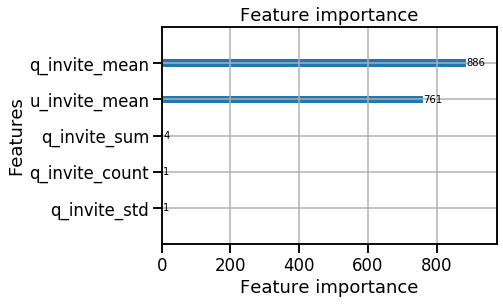

In [182]:
lgb.plot_importance(LGB)#然后就发现原来非常有用的盐值分数在这里一点用都没有？

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[421]	valid_0's auc: 0.713976	valid_0's binary_logloss: 0.419324	valid_0's rmse: 0.361845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.660921	valid_0's binary_logloss: 0.444287	valid_0's rmse: 0.37267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.739105	valid_0's binary_logloss: 0.437463	valid_0's rmse: 0.369709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[468]	valid_0's auc: 0.683012	valid_0's binary_logloss: 0.428547	valid_0's rmse: 0.364185
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.70338	valid_0's binary_logloss: 0.458467	valid_0's rmse: 0.378397
Training until validation scores don't improve for 50 rounds
Early stoppin

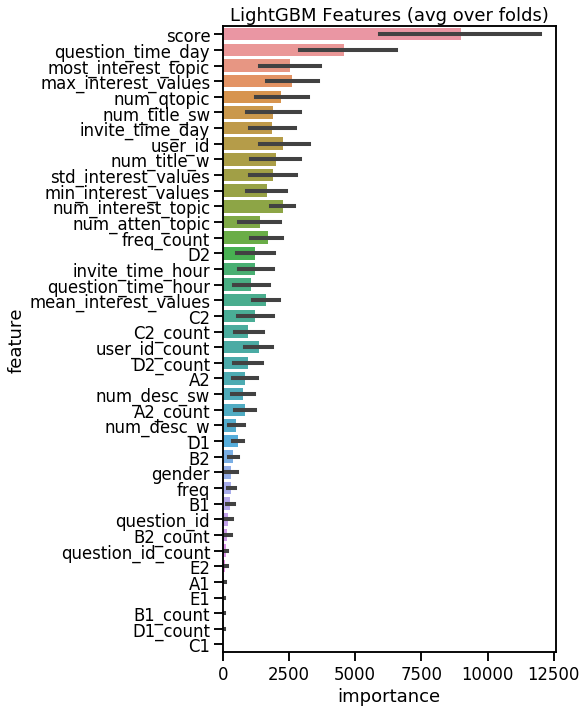

In [212]:
#这个是使用python API进行处理的，其实也完全一致，只不过想看一下详细的cv_results
kfold = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
kf = kfold.split(X_train, y_train)
cv_pred = np.zeros(X_test.shape[0])
valid_best_l2_all = 0
feature_importance_df = pd.DataFrame() 
#为了看一下这几个新增的特征效果到底有多好_(:з」∠)_删掉它们和上面那个模型对比一下
x_train=train.drop(['label','q_invite_mean',     
 'q_invite_sum',
 'q_invite_std',
 'q_invite_count',
 'u_invite_mean',
 'u_invite_sum',
 'u_invite_std',
 'u_invite_count',],axis=1)
Y_train=train['label']
x_train['invite_time_day'] = x_train['invite_time_day'].astype('int64')
x_train['invite_time_hour'] = x_train['invite_time_hour'].astype('int64')
x_train['question_time_day'] = x_train['question_time_day'].astype('int64')
x_train['question_time_hour'] = x_train['question_time_hour'].astype('int64')
for index, (tr_idx, va_idx) in enumerate(kf):
    xx_train,  xx_valid = x_train.iloc[tr_idx, :], x_train.iloc[va_idx, :]
    yy_train,  yy_valid = Y_train.iloc[tr_idx], Y_train.iloc[va_idx]
    dtrain = lgb.Dataset(xx_train, yy_train)      #用train方法的话一定要先行将Xtrain和ytrain转换为lgb的数据集形式
    dvalid = lgb.Dataset(xx_valid, yy_valid, reference=dtrain)
    
    bst = lgb.train(params,dtrain, num_boost_round=10000, 
                    valid_sets=dvalid, 
                    verbose_eval=-1,
                    early_stopping_rounds=50)
    cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0']['auc']
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(xx_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

cv_pred /= 9
valid_best_l2_all /= 9
print('cv score for valid is: ', 1/(1+valid_best_l2_all))
#为什么搞的这么复杂，因为自带函数不能输出这么好看_(:з」∠)_
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
display_importances(feature_importance_df)

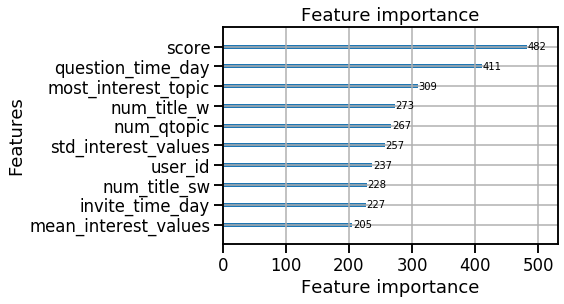

In [213]:
lgb.plot_importance(bst,max_num_features=10)

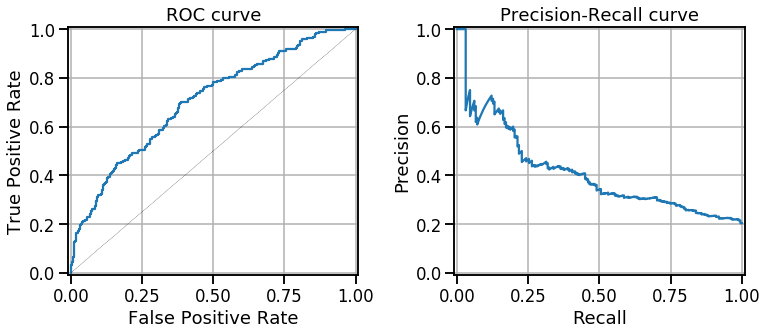

In [172]:
#画一下ROC曲线以及精确率-召回率曲线  可视化看一下拟合结果
#这个是不加新特征的
sns.set_context('talk')
fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)
y_prob = LGB.predict_proba(X_test)#画图就必须要用概率了
#ROC
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

#precision-recall
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test.fillna(0), y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

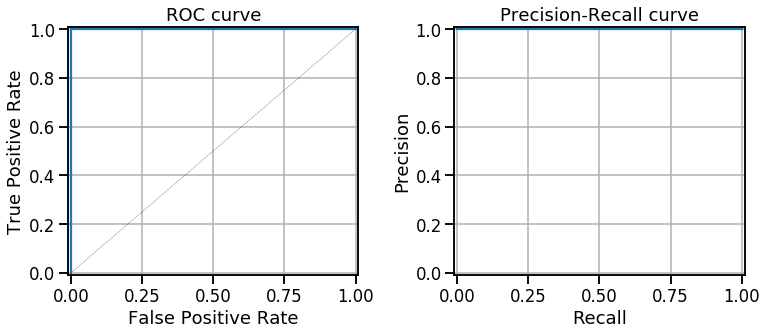

In [214]:
#画一下ROC曲线以及精确率-召回率曲线  可视化看一下拟合结果
#加新特征
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)
y_prob = LGB.predict_proba(X_test)#画图就必须要用概率了

#ROC
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

#precision-recall
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test.fillna(0), y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()
#拟合太好了，严重怀疑大数据就过拟合了_(:з」∠)_

In [ ]:
#既然要现场测试，那就先提前写一下 也不知道是要直接重给训练集还是怎么的，如果光是测试集的话就~
#就只改了测试集的名称以及读取其他照旧，如果给全部训练集的话替换文件从头跑一遍就好了_(:з」∠)_
new_test = pd.read_csv('dataset/newtest.txt', header=None, sep='\t')
y_new_test=new_test.loc[:,'label']
X_new_test = new_test.loc[:,feature_cols]

fold = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
#划分val和train
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train, y=y_train)):
    break
xx_train, xx_val, yy_train, yy_val = X_train.iloc[train_idx][feature_cols], X_train.iloc[val_idx][feature_cols], y_train.iloc[train_idx], y_train.iloc[val_idx]

tic=time.time()
LGB=lgb.LGBMClassifier(n_estimators=2000,boosting_type='gbdt', num_leaves=64, learning_rate=0.01, 
                           max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                           min_child_weight=5, min_child_samples=10, subsample=0.8, subsample_freq=1,
                           colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, n_jobs=-1, silent=True)
LGB.fit(xx_train, yy_train,
                  eval_metric=['logloss'],
                  eval_set=[(xx_val, yy_val)],
                  early_stopping_rounds=200)
##感觉auc做metric会过于早停，所以换成了logloss
# y_pred = LGB.predict_proba(X_test)[:, 1]    #测概率用这个
y_new_pred = LGB.predict(X_new_test)                  #直接输出分类结果
print('训练集分数：', LGB.score(xx_train,yy_train),'测试集分数',LGB.score(X_new_test,y_new_test))
def accuracy(real, predict):    #和测试集一致就记上
    return sum(real == predict) / float(real.shape[0])
print("测试集结果比对",accuracy(y_new_test, y_new_pred))  
#用来输出训练中分数结果情况的一个包  比较直观(*^▽^*)
cr = classification_report(y_new_test.round(), y_new_pred.round())
print(cr)
score_df = pd.DataFrame({'accuracy': accuracy_score(y_new_test.round(), y_new_pred.round()),
                         'precision': precision_score(y_new_test.round(), y_new_pred.round()),
                         'recall': recall_score(y_new_test.round(), y_new_pred.round()),
                         'f1': f1_score(y_new_test.round(), y_new_pred.round()),
                         'auc': roc_auc_score(y_new_test.round(), y_new_pred.round())},
                         index=pd.Index([0]))
print(score_df)
toc = time.time()
print('Used time: %d' % int(toc-tic))